In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [2]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


In [3]:

#神经网络模型
class Net(nn.Module):
    def __init__(self, num_output_channels):
        super(Net, self).__init__()

        # 第一层卷积，使用64个大小为3x3的卷积核，输入数据的shape为2x64x64，使用ReLU激活函数。
        # 输入通道数为2，输出通道数恒为64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        
        self.dropout1 = nn.Dropout(p=0.5)  # 设置dropout概率为0.5

        self.relu1 = nn.ReLU()

        # 第二层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.dropout2 = nn.Dropout(p=0.5)  # 设置dropout概率为0.5

        self.relu2 = nn.ReLU()

        # 第三层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.dropout3 = nn.Dropout(p=0.5)  # 设置dropout概率为0.5

        self.relu3 = nn.ReLU()

        # 第四层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # 第五层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        # 第六层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.dropout4 = nn.Dropout(p=0.5)  # 设置dropout概率为0.5

        self.relu6 = nn.ReLU()

        # 第七层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数,输出数据为4*64*64
        # 输入通道数为64，输出通道数恒为4
        self.conv7 = nn.Conv2d(64, num_output_channels, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        x = self.conv1(x)  # x:torch.Size([10, 2, 64, 64])
        
        x = self.dropout1(x)  # 在全连接层后应用dropout
        
        x = self.relu1(x)

        x = self.conv2(x)  # x:torch.Size([10, 64, 64, 64])
        
        x = self.dropout2(x)  # 在全连接层后应用dropout

        x = self.relu2(x)

        x = self.conv3(x)  # x:  torch.Size([10, 64, 64, 64])
        
        x = self.dropout3(x)  # 在全连接层后应用dropout

        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv6(x)

        x = self.dropout4(x)  # 在全连接层后应用dropout

        x = self.relu6(x)

        x = self.conv7(x)

        # 输出数据shape: torch.Size([10, 4, 64, 64]),10是batch_size大小
        return x



In [4]:
def train(num_output_channels):
    
    import time
    start_time = time.time()

    # 定义一个batch包含的样本数目
    batch_size =512

    # 生成数据集
    x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.05)

    # 设置种子数
    seed = 42
    torch.manual_seed(seed)

    # 划分数据集
    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    # 划分数据集
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)


    # 创建模型实例，并将模型移动到GPU设备上进行计算
    net = Net(num_output_channels).to(device)
    
    # 加速训练：如果有多个GPU，则使用DataParallel模块
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
        print("采用DataParallel加速，device_count个数为：",str(torch.cuda.device_count()))
        
    # 定义损失函数为均方误差
    criterion = nn.MSELoss()  # 将预测值与真实标签之间的差值求平方和，再除以样本数n来得到平均损失值

    # 定义优化器为Adam优化器,设置学习率为0.001
    optimizer = optim.Adam(net.parameters(),lr = 0.001)

    print('begin to train!!!')

    # 训练模型
    num_epochs = 100  # 训练轮数
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 将参数的梯度设为0
            optimizer.zero_grad()

            # 前向传播+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])
            loss.backward()  # 有了损失值后，就可以根据反向传播算法来更新模型参数，使得预测值更接近真实标签。
            optimizer.step()

            # 统计损失值
            running_train_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
                        # 每20个batch打印一次平均损失值，这里batch-size=10,相当于每100个样本打印一次loss
#             if i % 20 == 19:
#                 print('[epoch:  %d, batch:%5d] train loss: %.3f' %
#                       (epoch + 1, i + 1, running_train_loss))
        print("running_train_loss:",running_train_loss)
        train_time_epoch = time.time()
        train_loss.append(running_train_loss)
            

                
        running_test_loss = 0.0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播(预测)+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])

            # 统计损失值
            running_test_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
        print("running_test_loss:",running_test_loss)        
        test_loss.append(running_test_loss)
        print("已完成第：",str(epoch+1),"个epoch!截至该epoch，数据训练用了",str(train_time_epoch-start_time),"秒！")
        #已完成第： 1 个epoch!该epoch的数据训练用了 89.0041823387146 秒！

    end_time = time.time()
    process_time = end_time - start_time
    print(f"模型训练和测试共用了: {process_time} 秒！")#预处理data用了: 705.8258590698242 秒！
    print('all of tasks Finished')
    return train_loss,test_loss


"""
已完成第： 60 个epoch!
模型训练和测试共用了: 2325.386168241501 秒！
"""
train_loss,test_loss  = train(num_output_channels=4)
print(train_loss)
print(test_loss)
# 将数据写入文件，格式只能为二进制,二进制数据无法查看，想查看的话可以将其写入到txt里面或者用deebug查看
np.save('./data/lossa/add_dropout_100_0.001_512.npy', np.array([train_loss,test_loss]))

采用DataParallel加速，device_count个数为： 4
begin to train!!!
running_train_loss: 845.4711256027222
running_test_loss: 42.58332800865173
已完成第： 1 个epoch!截至该epoch，数据训练用了 132.39899826049805 秒！
running_train_loss: 790.1435091495514
running_test_loss: 41.81186079978943
已完成第： 2 个epoch!截至该epoch，数据训练用了 268.28921580314636 秒！
running_train_loss: 776.0659699440002
running_test_loss: 41.05905795097351
已完成第： 3 个epoch!截至该epoch，数据训练用了 404.8132870197296 秒！
running_train_loss: 763.1513984203339
running_test_loss: 40.32009816169739
已完成第： 4 个epoch!截至该epoch，数据训练用了 538.6961495876312 秒！
running_train_loss: 754.3648798465729
running_test_loss: 39.90351939201355
已完成第： 5 个epoch!截至该epoch，数据训练用了 674.758572101593 秒！
running_train_loss: 749.0672783851624
running_test_loss: 39.66789937019348
已完成第： 6 个epoch!截至该epoch，数据训练用了 811.196780204773 秒！
running_train_loss: 744.1376051902771
running_test_loss: 39.4101083278656
已完成第： 7 个epoch!截至该epoch，数据训练用了 947.6004645824432 秒！
running_train_loss: 739.3807592391968
running_test_loss: 3

running_train_loss: 707.9509979486465
running_test_loss: 37.58596205711365
已完成第： 65 个epoch!截至该epoch，数据训练用了 8011.898236751556 秒！
running_train_loss: 707.7268198728561
running_test_loss: 37.67129957675934
已完成第： 66 个epoch!截至该epoch，数据训练用了 8101.650300979614 秒！
running_train_loss: 707.8688645362854
running_test_loss: 37.6851122379303
已完成第： 67 个epoch!截至该epoch，数据训练用了 8191.222483158112 秒！
running_train_loss: 707.5173414945602
running_test_loss: 37.80944752693176
已完成第： 68 个epoch!截至该epoch，数据训练用了 8280.771628379822 秒！
running_train_loss: 707.5535666942596
running_test_loss: 37.619811058044434
已完成第： 69 个epoch!截至该epoch，数据训练用了 8370.32254743576 秒！
running_train_loss: 707.1491882801056
running_test_loss: 37.657620668411255
已完成第： 70 个epoch!截至该epoch，数据训练用了 8460.011637926102 秒！
running_train_loss: 707.3623667955399
running_test_loss: 37.62704014778137
已完成第： 71 个epoch!截至该epoch，数据训练用了 8549.551356077194 秒！
running_train_loss: 707.0108609199524
running_test_loss: 37.60494363307953
已完成第： 72 个epoch!截至该epoch，数据训练

In [5]:
print(all_data.shape)
print(all_label.shape)


torch.Size([192000, 2, 64, 64])
torch.Size([192000, 4, 64, 64])


In [14]:
train_loss,test_loss = np.load('./data/lossa/add_dropout_100_0.001_512.npy')
print(train_loss)

[845.4711256  790.14350915 776.06596994 763.15139842 754.36487985
 749.06727839 744.13760519 739.38075924 736.22243571 733.51576376
 731.83245921 730.00075805 728.38695884 727.26346636 726.01613045
 725.28728414 723.74731624 722.79417646 722.1693126  721.44007254
 720.67799008 719.988585   719.11547887 718.73636019 718.38066983
 718.07727492 717.0184139  716.27365637 716.44741094 716.01084471
 715.43435037 715.10584974 714.99236596 714.27793145 714.10774779
 713.90192342 713.4959029  713.18047774 712.87505138 712.7617414
 712.38210237 712.27033162 711.9976306  711.68634629 711.47884548
 711.145877   710.95173419 710.66005993 710.90550876 710.44009256
 710.23064494 709.8627156  709.70553935 709.3139329  709.38214684
 709.75801218 708.97833729 709.16887295 708.68337131 708.66567433
 708.47566378 708.32501161 708.29905617 708.20202947 707.95099795
 707.72681987 707.86886454 707.51734149 707.55356669 707.14918828
 707.3623668  707.01086092 706.75299299 706.49748421 706.49567509
 706.695669

[0.00463268, 0.00433114, 0.00425439, 0.00418311, 0.00413377, 0.00410636, 0.00407895, 0.00405154, 0.00403509, 0.00401864, 0.00400768, 0.00400219, 0.00399123, 0.00398575, 0.00398026, 0.00397478, 0.00396382, 0.00395833, 0.00395833, 0.00395285, 0.00394737, 0.00394189, 0.00394189, 0.0039364, 0.0039364, 0.0039364, 0.00393092, 0.00392544, 0.00392544, 0.00392544, 0.00391996, 0.00391996, 0.00391447, 0.00391447, 0.00391447, 0.00390899, 0.00390899, 0.00390899, 0.00390351, 0.00390351, 0.00390351, 0.00390351, 0.00389803, 0.00389803, 0.00389803, 0.00389803, 0.00389254, 0.00389254, 0.00389254, 0.00389254, 0.00389254, 0.00388706, 0.00388706, 0.00388706, 0.00388706, 0.00388706, 0.00388158, 0.00388706, 0.00388158, 0.00388158, 0.00388158, 0.00388158, 0.00388158, 0.00388158, 0.0038761, 0.0038761, 0.0038761, 0.0038761, 0.0038761, 0.0038761, 0.0038761, 0.0038761, 0.00387061, 0.00387061, 0.00387061, 0.00387061, 0.00387061, 0.00387061, 0.00387061, 0.00386513, 0.00387061, 0.00386513, 0.00386513, 0.00386513, 0.

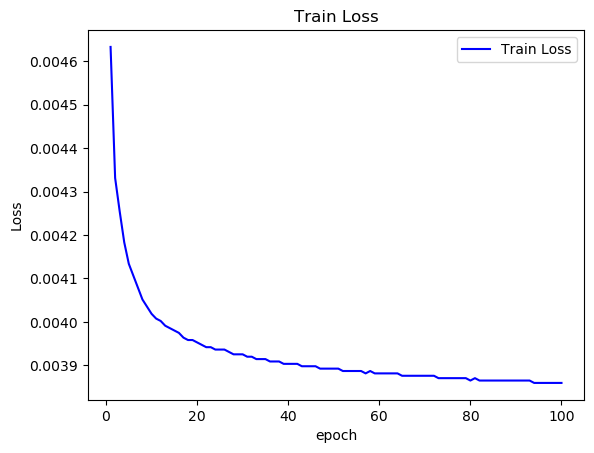

In [15]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.95), 8) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[0.004375, 0.00427083, 0.00427083, 0.00416667, 0.0040625, 0.0040625, 0.0040625, 0.0040625, 0.0040625, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00395833, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00395833, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417, 0.00385417

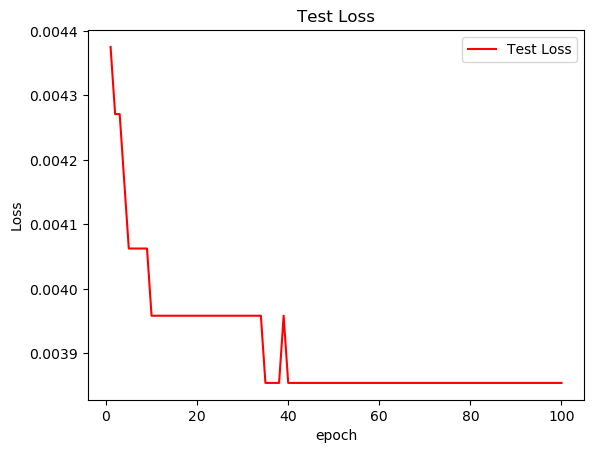

In [16]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)

test_loss = [round(int(a)/(all_data.shape[0]*0.05), 8) for a in test_loss]

print(test_loss)

# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()